## Instructions
Please be patient while waiting for the environment to load; it may take a few minutes. 
Once the notebook has finished loading, in the top bar, select `Kernel`--> `Restart & Run All`. 
Once cell has finished running, you should see a plot with sliders appear at the bottom.
Enjoy!

In [1]:
# Importing libraries and dependencies
import sys
sys.path.append('python/')
import NGC5533_functions as funcNGC5533        # Functions for the components of NGC 5533
import NGC5533_traced_curves as dataNGC5533    # Traced data of Galaxy NGC 5533
import NGC5533_fitting as fitNGC5533           # Fitting parameters for best fit values
import dataPython as dp

import numpy as np
import matplotlib.pyplot as plt                # Plotting
%matplotlib inline

import scipy.integrate as si                   # Integration
from ipywidgets import interactive, fixed, FloatSlider, HBox, Layout, Button, Label, Output, VBox
from IPython.display import display, clear_output
from IPython.display import Javascript

import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")              # Ignore warnings

## Introduction to dark matter

Rotation curves of some spiral galaxies are an indication of the existence of a "missing matter" called dark matter. The reason it is labeled as "missing" is because there seem to be a mass that is not interacting with light but affecting the velocity of stars and gas. According to Newton's law of gravitation, the mass is proportional to the force and therefore the motion of matter in a galaxy. <br>
Setting the gravitation force and the centripetal force equal, the rotational velocity can be computed in terms of mass ($M$) and distance ($r$) from the center. 

>__Newton's Law of Gravitation__: <br>
    \begin{equation}
    F_g = G \frac{Mm}{r^2}
    \end{equation}<br>
>__Centripetal Force__: <br>
    \begin{equation}
    F_c = \frac{mv^2}{r}
    \end{equation}<br>
>__Rotational velocity__: <br>
    \begin{equation}
    v = \sqrt{\frac{GM}{r}}
    \end{equation}<br>

Since visible matter can be measured through photometry, a theoretical rotation curve can be computed applying the above equations. <br>
However, as you will discover in the following exercises, this theoretical curve does not always agree with the measured velocities. 

## Interactive widget with variable dark matter component - Galaxy: NGC 5533

In the following activity, you can experiment adding or removing dark matter and investigating how the total velocity of stars and gases change in a galaxy. 

## Measured data points

1. Import the measured data points for the NGC 5533 galaxy. These are measured velocities of stars and gas in the galaxy as a function of radius. The data points were traced from Figure 4. in Noordermeer (2008). 

In [2]:
data = dp.getXYdata_wXYerr('data/NGC5533/noord-120kpc-datapoints.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

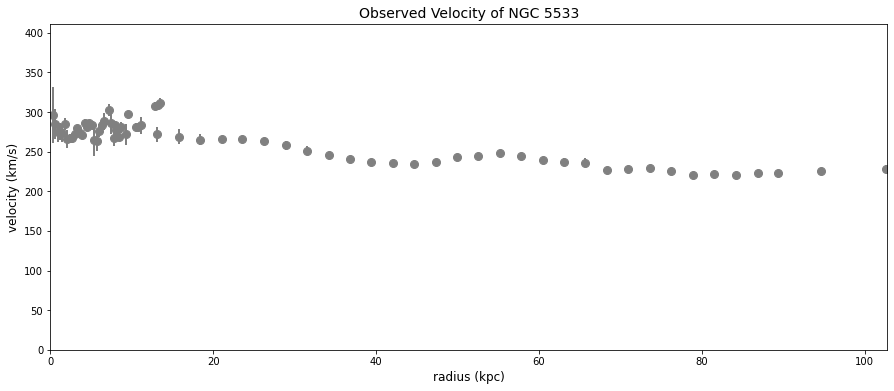

In [3]:
# Plot 
plt.figure(figsize=(15,6))                                               # size of the galaxy
plt.errorbar(r_dat,v_dat,yerr=v_err1, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2)  # plot datapoints with errorbars
plt.xlabel('radius (kpc)',size=12)                                       # label x-axis
plt.ylabel('velocity (km/s)',size=12)                                    # label y-axis
plt.title(str('Observed Velocity of NGC 5533'), size=14)                 # title of the plot
plt.xlim(0,np.max(r_dat)+0.2)                                            # range of the x-axis
plt.ylim(0,np.max(v_dat)+100)                                            # range of the y-axis
plt.show()                                                               # show the plot

## Components

The stars and gas in a galaxy can be categorized into components depending on the shape of the distribution. These components are then added in quadrature to calculate the total velocity or the rotation curve of a galaxy. In the case of NGC 5533, we can define a central supermassive black hole, a central bulge, a flat disk, a mostly atomic gas, and a dark matter halo component. 

>__Total velocity__: <br>
    \begin{equation}
    v_{total}(r) = \sqrt{\lvert v_{gas}\rvert v_{gas} + \Upsilon _{bulge} \lvert v_{bulge}\rvert v_{bulge} + \Upsilon _{disk} \lvert v_{disk}\rvert v_{disk} + \lvert v_{halo}\rvert v_{halo}}
    \end{equation}<br>

2. Import the relevant functions or traced curves from the NGC5533_functions.py library.

In [4]:
def blackhole(r,Mbh):
    return funcNGC5533.bh_v(r,Mbh,load=False)

def bulge(r,bpref):
    return bpref*funcNGC5533.b_v(r,load=True)

def disk(r,dpref):
    return dpref*funcNGC5533.d_thief(r)

def gas(r,gpref):
    return gpref*funcNGC5533.g_thief(r)

def halo(r,rc,rho0):
    return funcNGC5533.h_v(r,rc,rho0,load=False)

# Total velocity containing all components
def total_all(r,Mbh,bpref,dpref,gpref,rc,rho0):
    total = np.sqrt(blackhole(r,Mbh)**2 
                    + bulge(r,bpref)**2 
                    + disk(r,dpref)**2
                    + gas(r,gpref)**2
                    + halo(r,rc,rho0)**2)
    return total

# Total velocity of baryonic or luminous matter (no dark matter component)
def total_bary(r,Mbh,bpref,dpref,gpref):
    total = np.sqrt(blackhole(r,Mbh)**2 
                    + bulge(r,bpref)**2 
                    + disk(r,dpref)**2
                    + gas(r,gpref)**2)
    return total

## Parameters

The scaling parameters for each component can be found by fitting the total velocity to the measured data points. 

3. Import the calculated fitting parameters for our widget from the NGC5533_fitting.py library. 

In [5]:
best_Mbh = fitNGC5533.f_Mbh
best_bpref = fitNGC5533.f_bpref
best_dpref = fitNGC5533.f_dpref
best_gpref = fitNGC5533.f_gpref
best_rc = fitNGC5533.f_rc
best_rho0 = fitNGC5533.f_rho00

## Total dark matter mass

4. Assuming the density of the dark matter is isothermal, we can calculate the total expected dark matter mass enclosed in the given radius. <br>

>__Isothermal Density__: <br>
    \begin{equation}
    \rho(r) = \rho_{0} \big[1 + \frac{r}{r_c} \big ]^{-1}
    \end{equation}<br>
    
   >where:<br>
        $G$ = gravitational constant<br>
        $\rho_0$ = central mass density (in solar mass/$\rm kpc^3$)<br>
        $r_c$ = core radius (in kpc)<br>

In [6]:
# Equation for isothermal density
def density_iso(r,rc,rho0):
    density = rho0 * (1 + (r/rc)**2)**(-1)
    return density

>__Mass as a function of radius__: <br>
    \begin{equation}
    M(r) = 4 \pi r^2 \rho(r)
    \end{equation}

In [7]:
# Equation for mass as a function of radius
def mass_function(r,rc,rho0):
    mass = 4 * np.pi * r**2 * density_iso(r,rc,rho0) 
    return mass

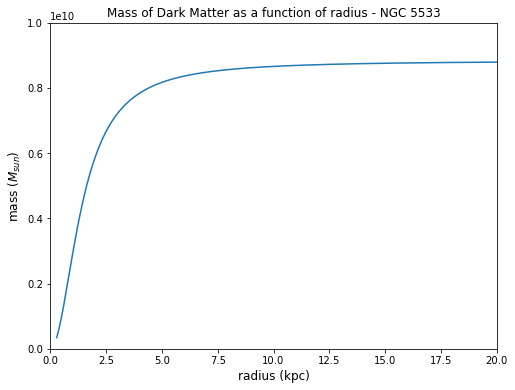

In [8]:
# Plot to visualize the mass distribution in the NGC 5533 galaxy for radii between 0 and 20 kpc
r = np.linspace(np.min(r_dat),np.max(r_dat),1000)
plt.figure(figsize=(8,6))                                                
plt.plot(r,mass_function(r,best_rc,best_rho0)) 
plt.xlabel('radius (kpc)',size=12)                                       
plt.ylabel('mass ($M_{sun}$)',size=12)                                   
plt.title(str('Mass of Dark Matter as a function of radius - NGC 5533'), size=12) 
plt.xlim(0,20)
plt.ylim(0,1e10)                                        
plt.show() 

5. Integrate to calculate the total mass enclosed.

>__Total mass enclosed__: <br>
    \begin{equation}
    M_{total} = \int_{0}^{r} M(r) dr
    \end{equation}

In [9]:
# Integrate to calculate total mass enclosed 
TotalMass = lambda rc,rho0: si.quad(mass_function, 0, np.max(r_dat), args=(rc,rho0))[0]

# Print total mass of dark matter in NGC 5533
print("The total mass of dark matter in the galaxy NGC 5533 is about {:.3e} solar masses.".format(TotalMass(best_rc,best_rho0)))

The total mass of dark matter in the galaxy NGC 5533 is about 8.867e+11 solar masses.


## Define plotting function and sliders for widget

The interactive widget is defined with two adjustable sliders that controls the two dark matter parameters defined previously. All other parameters are fixed to focus on the dark matter component only. 

In [10]:
# Plotting function
def f(rc,rho0):
        
    # Define radius
    r = np.linspace(np.min(r_dat),np.max(r_dat),1000)
    
    # Plot
    plt.figure(figsize=(11,7))
    plt.xlim(0,np.max(r_dat)+0.2)
    plt.ylim(0,np.max(v_dat)+100)
    
    plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')     # Measured data points
    plt.plot(r,blackhole(r,best_Mbh),label=("Central Supermassive Black Hole"),color='black') # Black hole component
    plt.plot(r,bulge(r,best_bpref),label=("Bulge"),color='orange')       # Bulge component
    plt.plot(r,disk(r,best_dpref),label=("Disk"),color='purple')         # Disk component 
    plt.plot(r,gas(r,best_gpref),label=("Gas"),color='blue')             # Gas component
    plt.plot(r,halo(r,rc,rho0),label=("Halo"),color='green')        # Dark matter halo component
    plt.plot(r,total_all(r,best_Mbh,best_bpref,best_dpref,best_gpref,rc,rho0),label=("Total Curve"),color='red')    # Total velocity with dark matter
    plt.plot(r,total_bary(r,best_Mbh,best_bpref,best_dpref,best_gpref),label=("Luminous Matter"),linestyle='--')    # Total velocity without dark matter
    plt.fill_between(r,dataNGC5533.greyb_bottom(r),dataNGC5533.greyb_top(r),color='#dddddd',label="Confidence Band")    # Confidence band
    plt.title("Interactive Rotation Curve - Galaxy: NGC 5533",fontsize=20)
    plt.xlabel("Radius (kpc)")
    plt.ylabel("Velocity (km/s)")
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")              # Put legend outside of the plot
    
    # Chi squared and reduced chi squared
    # Residuals
    residuals = v_dat - total_all(r_dat,best_Mbh,best_bpref,best_dpref,best_gpref,rc,rho0)
    # Error
    error = np.sqrt(v_err1**2 + dataNGC5533.band**2)
    # Chi squared
    chisquared = np.sum(residuals**2/error**2)
    # Degrees of freedom
    dof = len(r_dat) - 6                 # number of degrees of freedom = number of observed data - number of fitting parameters
    # Reduced chi squared
    reducedchisquared = chisquared / dof 
    
    # Annotation
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(82,373,r"$\chi^2$: {:.5f}".format(chisquared)+'\n'+r"Reduced $\chi^2$: {:.5f}".format(reducedchisquared),bbox=props,size=10)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(69.5,350,r"Total Dark Matter Mass: {:.2e} $M_\odot$".format(TotalMass(rc,rho0)),bbox=props,size=10)
    plt.annotate('Data source: E. Noordermeer. The rotation curves of flattened Sérsic bulges. MNRAS,385(3):1359–1364, Apr 2008',
            xy=(0, 0), xytext=(0,5),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            size=10, ha='left', va='bottom')
    
    plt.show()

In [11]:
# Appearance
style = {'description_width': 'initial'}
layout = {'width':'600px'}

# Sliders
rc = FloatSlider(min=0.1, max=5, step=0.1, 
                    value=best_rc, 
                    description='Halo Core Radius [kpc]', 
                    readout_format='.2f', 
                    orientation='horizontal', 
                    style=style, layout=layout)
rho0 = FloatSlider(min=0, max=1e9, step=1e7, 
                    value=best_rho0, 
                    description=r'Halo Central Mass Density [$M_{\odot} / kpc^3$]', 
                    readout_format='.2e', 
                    orientation='horizontal', 
                    style=style, layout=layout)

# Interactive widget
def interactive_plot(f):
    interact = interactive(f,
                           rc = rc,
                           rho0 = rho0,
                           continuous_update=False)
    return interact

# Button to revert back to Best Fit
button = Button(
    description="Best Fit",
    button_style='warning',
    icon='check')
out = Output()

def on_button_clicked(_):
    rc.value = best_rc
    rho0.value = best_rho0

button.on_click(on_button_clicked)

## What do rotation curves look like with and without dark matter?
In this activity, you can visualize how important dark matter is to accurately describe observed data (marked in blue points with error bars below). <br>
How much dark matter is in a given galaxy to account for our observations?

6. Play around with the halo parameters and see how incorporating a dark matter component allows us to more accurately match our observations.

A reduced $\chi^2$ close to 1 is generally considered a good fit. So reduced $\chi^2$ far higher is not a good fit. Moreover, a lot lower than 1 suggests a poor theoretical model (that is, the model probably doesn't accurately describe the real universe or it is simply connecting the measured data points).

In [12]:
# Widget
VBox([button,out,interactive_plot(f)])

## Slider Key

>Central mass density ($\rho_0$): The central mass density is the density at the center of the galaxy, changing this value changes the magnitude of the dark matter curve.<br>
>Core radius ($r_c$): The core radius (also called "cutoff radius" or "scale radius") indicates where the density falls off by a factor of e (~2.7). Adjusting this factor changes where the "bump" of the curve is located.

>$kpc$ = kiloparsec, equal to 3,260 light years, or $1.917 \times 10^{16}$ miles <br>
>$km/s$ = kilometers per second (velocity unit)<br>
>$M_{\odot}$ = solar masses (X number of masses equal to our sun), approximately equal to $1.989 \times 10^{30}$ kilograms <br>
>$M_{\odot} / kpc^3$ = solar masses per kiloparsec cubed (density unit = mass/volume) <br>

## References: 
>Carroll, B. W., &amp; Ostlie, D. A. (2018). **An Introduction to Modern Astrophysics**. Cambridge University Press. <br><br>
Jimenez, Raul, Licia Verde, and S. Peng Oh. **Dark halo properties from rotation curves.** _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Noordermeer, E., &amp; Van Der Hulst, J. M. (2007). **The stellar mass distribution in early-type disc galaxies: Surface Photometry and bulge–disc decompositions.** Monthly Notices of the Royal Astronomical Society, 376(4), 1480–1512. https://doi.org/10.1111/j.1365-2966.2007.11532.x <br><br>
>Noordermeer, E. (2008), **The rotation curves of flattened Sérsic bulges**. Monthly Notices of the Royal Astronomical Society, 385: 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x <br><br>
>Taylor, John Robert. __An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.__ 2nd ed. United States of America: University Science Books, 1997. 